### Importación de Tensorflow

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Importación de datos 

In [0]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot = True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


### verificando los datos de prueba

In [0]:
mnist.train.images.shape

(55000, 784)

In [0]:
imagendemo=np.reshape(mnist.train.images[2,:],(28,28))

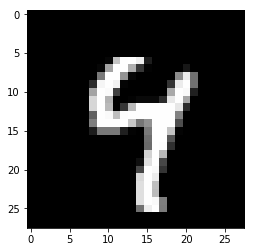

In [0]:
plt.imshow(imagendemo,cmap='gray')

In [0]:
def image_matrix(img):
    print('\n'.join([''.join(['{:4}'.format(int(round(item*255))) for item in row]) 
      for row in img]))

In [0]:
image_matrix(imagendemo)

   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   6 195 254 255 239  29   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   6 163 254 254 175  55   3   0   0   0   0  23   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0 121 254 254 148   8   0   0   0   0   0 140 237 112   0   0

### Declarando la arquitectura

Generando función 

In [0]:
# Agregar funcion para limpiar la gráfica 
# Evita duplicar elementos 
def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

In [0]:
def Neural_network_model(
    n_nodes_hl1=500,
    n_nodes_hl2=500,
    n_nodes_hl3=500,
    n_classes=10
    ):
    
    # limpiar gráficas anteriores 
    reset_graph()
    
    # Declarando las entradas y salidas
    x=tf.placeholder('float',[None,784])
    y=tf.placeholder('float')
    
    # Declarando las variables 
    
    hidden_1_layer = {'weights':tf.Variable(tf.random_normal([784, n_nodes_hl1])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl1]))}

    hidden_2_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl1, n_nodes_hl2])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl2]))}

    hidden_3_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl2, n_nodes_hl3])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl3]))}

    output_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl3, n_classes])),
                    'biases':tf.Variable(tf.random_normal([n_classes])),}
    
    
    # Declarando la arquitectura
    
    l1 = tf.add(tf.matmul(x,hidden_1_layer['weights']), hidden_1_layer['biases'])
    l1 = tf.nn.relu(l1)

    l2 = tf.add(tf.matmul(l1,hidden_2_layer['weights']), hidden_2_layer['biases'])
    l2 = tf.nn.relu(l2)

    l3 = tf.add(tf.matmul(l2,hidden_3_layer['weights']), hidden_3_layer['biases'])
    l3 = tf.nn.relu(l3)

    output = tf.matmul(l3,output_layer['weights']) + output_layer['biases']
    
    # Declarando la funcion de costo y optimizador
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=output
                                                                   , labels=y) )
    tf.summary.scalar("costo",cost)
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    #generar logs
    summaries = tf.summary.merge_all()
    
    return dict(
              x=x,
              y=y,
              output=output,
              cost=cost,
              optimizer=optimizer,
              #logs
              summaries=summaries,
              #variables para guardar 
              saver = tf.train.Saver()  
              )

In [0]:
#Prueba del modelo
Neural_network_model()

{'cost': <tf.Tensor 'Mean:0' shape=() dtype=float32>,
 'optimizer': <tf.Operation 'Adam' type=NoOp>,
 'output': <tf.Tensor 'add:0' shape=(?, 10) dtype=float32>,
 'saver': <tensorflow.python.training.saver.Saver at 0x1e4818ac748>,
 'summaries': <tf.Tensor 'Merge/MergeSummary:0' shape=() dtype=string>,
 'x': <tf.Tensor 'Placeholder:0' shape=(?, 784) dtype=float32>,
 'y': <tf.Tensor 'Placeholder_1:0' shape=<unknown> dtype=float32>}

## función de entrenamiento  y prueba

In [0]:
def train_neural_network(DNN, hm_epochs=10,batch_size=100,save=False):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        writer = tf.summary.FileWriter("./LOG")
        tf.summary.FileWriter.add_graph(writer,sess.graph)

        for epoch in range(hm_epochs):
            epoch_loss = 0
            for _ in range(int(mnist.train.num_examples/batch_size)):
                epoch_x, epoch_y = mnist.train.next_batch(batch_size)
                feed_dict={DNN["x"]: epoch_x, 
                           DNN["y"]: epoch_y}
                _, c, prediction,y,summ   = sess.run([DNN["optimizer"], DNN["cost"]
                                                 , DNN["output"], DNN["y"],DNN["summaries"]], 
                                                feed_dict=feed_dict)
                epoch_loss += c

            ##print('Epoch', epoch, 'completed out of',hm_epochs,'loss:',epoch_loss)
            if (epoch%2 == 0):
                writer.add_summary(summ,epoch)
                
                
        if isinstance(save, str):
            ENCname="./SVE/"+save+".ckpt"
            DNN['saver'].save(sess, ENCname)
        
        ## prueba con el conjunto de entrenamiento 
        correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        print('Accuracy:',accuracy.eval())
        
        #Prueba con datos nunca antes vistos  
        prediction,y   = sess.run([DNN["output"], DNN["y"]], feed_dict={DNN["x"]:mnist.test.images, DNN["y"]:mnist.test.labels})
        correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        print('Accuracy:',accuracy.eval())

In [0]:
DNN=Neural_network_model()
train_neural_network(DNN,save="vanilla")

Accuracy: 0.99
Accuracy: 0.953
